In [1]:
import pandas as pd
import geopandas as gpd
import geodatasets
import folium
from folium.plugins import MarkerCluster
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from shapely.geometry import Point
import seaborn as sns

# Setting the path for convenience
data_dir_fk = os.path.expanduser("~/multitressor/CREMP_CSV_Files")
data_dir_dt = os.path.expanduser("~/multitressor/DTCREMP_CSV_Files")
print(f"Environment ready. Data directory set to: {data_dir_fk}")

Environment ready. Data directory set to: /home/enrique.montes@CNS.local/multitressor/CREMP_CSV_Files


#### Load data and render map showing location of CREMP monitoring sites

In [2]:
# 1. Load the dataset
stations_path_fk = os.path.join(data_dir_fk, "CREMP_Stations_2024.csv")
stations_path_dt = os.path.join(data_dir_dt, "DTCREMP_Stations_2024.csv")
df_stations_fk = pd.read_csv(stations_path_fk)
df_stations_dt = pd.read_csv(stations_path_dt)
df_stations = pd.concat([df_stations_fk, df_stations_dt], ignore_index=True)

# 2. Initialize the map with Satellite Imagery
# We use Esri.WorldImagery for the satellite background
m = folium.Map(
    location=[24.8, -80.8], 
    zoom_start=8, 
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite'
)

# 3. Add stations to the map
marker_cluster = MarkerCluster().add_to(m)

for idx, row in df_stations.iterrows():
    if pd.notnull(row['latDD']) and pd.notnull(row['lonDD']):
        # Popup string formatted as a list-style block
        popup_text = f"""
        Station: {row.get('Site_name', 'N/A')}
        <br>ID: {row.get('StationID', 'N/A')}
        <br>Habitat: {row.get('Habitat', 'N/A')}
        <br>First Surveyed: {row.get('First_Year_surveyed', 'N/A')}
        <br>Depth: {row.get('Depth_ft', 'N/A')} ft
        """
        
        folium.Marker(
            location=[row['latDD'], row['lonDD']],
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=row.get('Site_name', 'Click for info')
        ).add_to(marker_cluster)

# Display the map
m

#### Benthic trend analysis and mapping

Linear Trend Analysis (Total Stony Coral Cover):


,SiteName,Slope,P_Value
29,Palmata Patch,0.001959,0.058564
48,Turtle,0.000477,0.159845
24,Mayer's Peak,0.000374,0.219726
50,West Turtle Shoal,0.000208,0.554128
13,Dove Key,0.000013,0.902454
32,Rattlesnake,-0.000043,0.796175
17,El Radabob,-0.000051,0.255487
26,Molasses Keys,-0.000054,0.205656
25,Molasses Deep,-0.000082,0.709174
42,Temptation Rock,-0.000090,0.827335


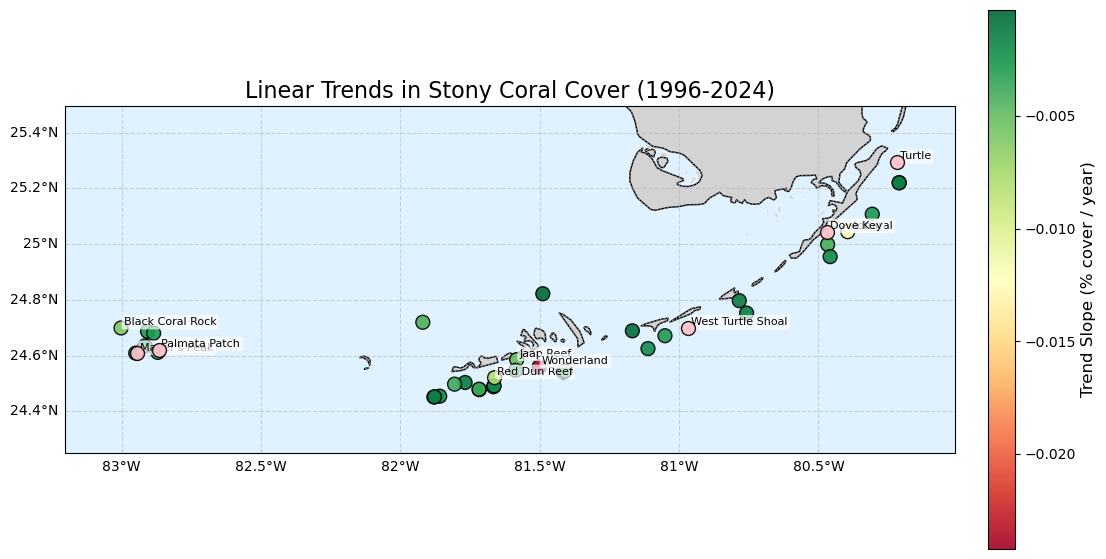

In [3]:
# Load data 
pcover_path_fk = os.path.join(data_dir_fk, "CREMP_Pcover_StonyCoralSpecies_2024.csv")
pcover_path_dt = os.path.join(data_dir_dt, "DTCREMP_Pcover_StonyCoralSpecies_2024.csv")
df_pcover_fk = pd.read_csv(pcover_path_fk)
df_pcover_dt = pd.read_csv(pcover_path_dt)
df_pcover = pd.concat([df_pcover_fk, df_pcover_dt], ignore_index=True)

# Calculate total stony coral cover per site per year
species_cols = df_pcover.columns[11:] 
df_pcover['Total_Cover'] = df_pcover[species_cols].sum(axis=1)
site_annual = df_pcover.groupby(['SiteName', 'SampleYear'])['Total_Cover'].mean().reset_index()

stats_list = []
for site in site_annual['SiteName'].unique():
    site_data = site_annual[site_annual['SiteName'] == site]
    if len(site_data) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(site_data['SampleYear'], site_data['Total_Cover'])
        stats_list.append({'SiteName': site, 'Slope': slope, 'P_Value': p_value})

df_trends = pd.DataFrame(stats_list)

# Display the trend table
print("Linear Trend Analysis (Total Stony Coral Cover):")
display(df_trends.sort_values('Slope', ascending=False).head(10)) 

# Merge with coordinates
df_coords = df_stations[['Site_name', 'latDD', 'lonDD']].drop_duplicates(subset='Site_name')
df_map_data = pd.merge(df_trends, df_coords, left_on='SiteName', right_on='Site_name')

# Filter data to only include significant trends
df_significant = df_map_data[df_map_data['P_Value'] < 0.05].copy()
df_pos = pd.merge(df_trends[df_trends['Slope'] >= 0], df_coords, left_on='SiteName', right_on='Site_name')

# Setup the figure with a PlateCarree projection
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add high-resolution geographic features
# '10m' provides the highest resolution for coastal details
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1)
ax.add_feature(cfeature.STATES.with_scale('10m'), linestyle=':', edgecolor='gray')
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#e0f2ff')

# Plot ONLY the significant trend dots
sc = ax.scatter(df_significant['lonDD'], df_significant['latDD'], 
                c=df_significant['Slope'], cmap='RdYlGn', 
                s=100, edgecolor='black', alpha=0.9, 
                transform=ccrs.PlateCarree(), zorder=3)

# 3. Plot stable/increasing sites (>= 0) as PINK
ax.scatter(df_pos['lonDD'], df_pos['latDD'], 
           color='pink', # Explicitly colored pink
           label='Stable/Increasing (≥ 0)',
           s=100, edgecolor='black', alpha=0.9, 
           transform=ccrs.PlateCarree(), zorder=4)

# Set the map extent to focus on the Florida Keys / study area
# [min_lon, max_lon, min_lat, max_lat]
ax.set_extent([df_map_data['lonDD'].min() - 0.2, df_map_data['lonDD'].max() + 0.2,
               df_map_data['latDD'].min() - 0.2, df_map_data['latDD'].max() + 0.2], 
              crs=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.03, shrink=0.7)
cbar.set_label('Trend Slope (% cover / year)', fontsize=12)

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5, zorder=2)
gl.top_labels = False
gl.right_labels = False

# Labels for significant sites (p < 0.05)
for idx, row in df_map_data.iterrows():
    if row['Slope'] <= -0.005 or row['Slope'] >= 0:
        ax.text(row['lonDD'] + 0.01, row['latDD'] + 0.01, row['SiteName'],
                fontsize=8, transform=ccrs.PlateCarree(),
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7, ec='none'))

plt.title('Linear Trends in Stony Coral Cover (1996-2024)', fontsize=16)
plt.show()

#### Species-level trend analysis

Species-Level Trend Analysis (All Sites Integrated):


,Species,Slope,P_Value,R_Squared
44,Total_Cover,-9.542411e-04,8.898706e-05,4.394769e-01
30,Orbicella_annularis_complex,-9.402700e-04,8.498909e-15,8.960874e-01
0,Acropora_palmata,-1.602639e-04,7.670165e-04,3.473965e-01
22,Millepora_complanata,-1.226721e-04,1.816419e-03,3.070220e-01
23,Montastraea_cavernosa,-1.128343e-04,7.059334e-03,2.394499e-01
36,Scleractinia,-9.438072e-05,2.413322e-05,4.893484e-01
8,Colpophyllia_natans,-4.841473e-05,3.206312e-01,3.652883e-02
9,Dendrogyra_cylindrus,-4.625771e-05,4.152204e-12,8.360099e-01
35,Pseudodiploria_strigosa,-3.398927e-05,4.552375e-04,3.708456e-01
11,Diploria_labyrinthiformis,-2.285889e-05,5.795284e-07,6.097877e-01


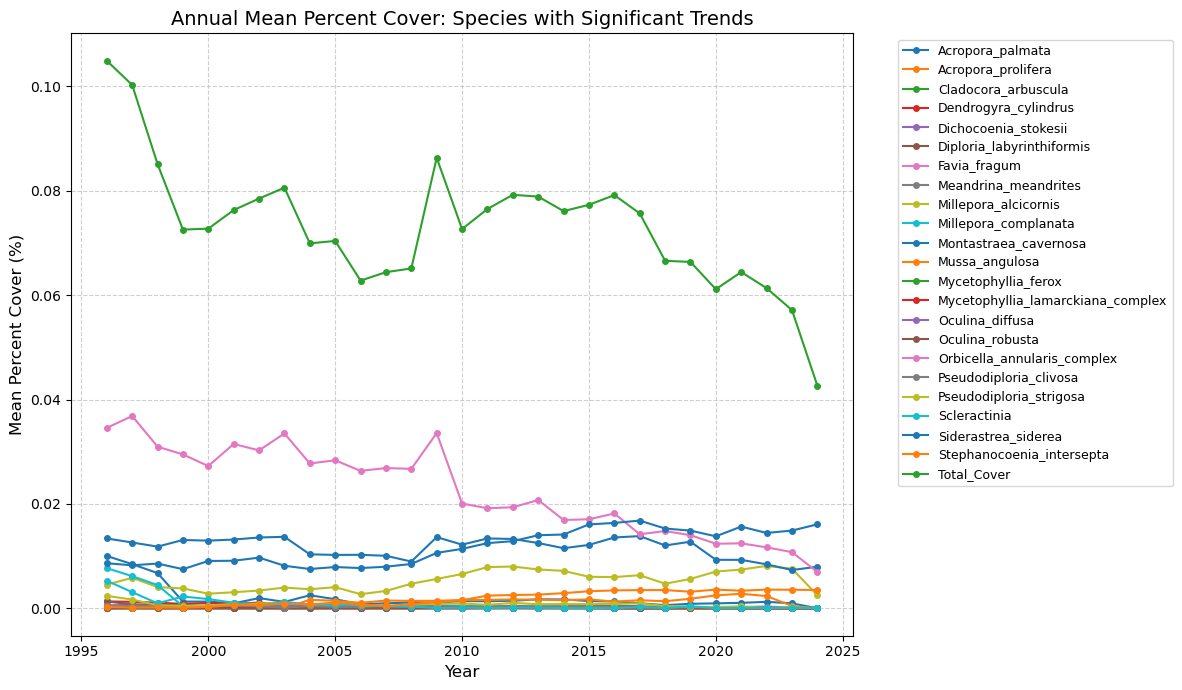

In [4]:
# Identify species columns (from index 11 onwards)
species_list = df_pcover.columns[11:].tolist()

# Aggregate data by Year for the entire region
# Calculate the mean percent cover for every species across all sites per year
species_annual = df_pcover.groupby('SampleYear')[species_list].mean().reset_index()

# Calculate Linear Trends for each species
species_stats = []

for species in species_list:
    # Remove years where the species might have zero data if necessary. 
    y = species_annual[species]
    x = species_annual['SampleYear']
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    species_stats.append({
        'Species': species,
        'Slope': slope,
        'P_Value': p_value,
        'R_Squared': r_value**2
    })

df_species_trends = pd.DataFrame(species_stats)

# Identify significant species (p < 0.05)
significant_species = df_species_trends[df_species_trends['P_Value'] < 0.05].copy()

print("Species-Level Trend Analysis (All Sites Integrated):")
display(df_species_trends.sort_values('Slope', ascending=True))

# Render Time Series Plot for Significant Species Only
if not significant_species.empty:
    plt.figure(figsize=(12, 7))
    
    for species in significant_species['Species']:
        plt.plot(species_annual['SampleYear'], species_annual[species], 
                 marker='o', markersize=4, label=f"{species}")

    plt.title('Annual Mean Percent Cover: Species with Significant Trends', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Mean Percent Cover (%)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("No species showed statistically significant trends.")

#### Check stations where a selected SPECIES shows a significant (p < 0.05) trend

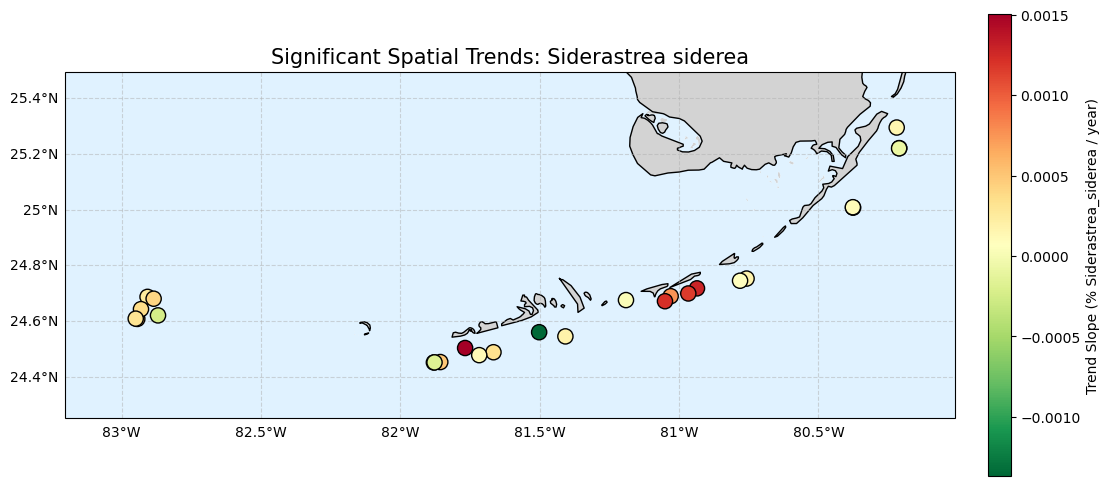

In [5]:
# --- Spatial Analysis for a Selected Species ---
selected_species = 'Siderastrea_siderea'

# Group by Site and Year for the specific species
site_species_annual = df_pcover.groupby(['SiteName', 'SampleYear'])[selected_species].mean().reset_index()

# Calculate trends for this species at each individual site
site_species_stats = []
for site in site_species_annual['SiteName'].unique():
    site_data = site_species_annual[site_species_annual['SiteName'] == site]
    if len(site_data) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(site_data['SampleYear'], site_data[selected_species])
        site_species_stats.append({'SiteName': site, 'Slope': slope, 'P_Value': p_value})

df_species_map = pd.DataFrame(site_species_stats)

# Merge with coordinates and filter for significance (p < 0.05)
df_species_map = pd.merge(df_species_map, df_coords, left_on='SiteName', right_on='Site_name')
df_sig_map = df_species_map[df_species_map['P_Value'] < 0.05].copy()

# Render the Map
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add High-Res Features
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1)
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#e0f2ff')

# Plot Trends
sc = ax.scatter(df_sig_map['lonDD'], df_sig_map['latDD'], 
                c=df_sig_map['Slope'], cmap='RdYlGn_r', 
                s=120, edgecolor='black', transform=ccrs.PlateCarree(), zorder=3)

# Add Legend/Colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.03)
cbar.set_label(f'Trend Slope (% {selected_species} / year)')

# Set extent and labels
ax.set_extent([df_coords['lonDD'].min()-0.2, df_coords['lonDD'].max()+0.2, 
               df_coords['latDD'].min()-0.2, df_coords['latDD'].max()+0.2])
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

plt.title(f'Significant Spatial Trends: {selected_species.replace("_", " ")}', fontsize=15)
plt.show()

#### Check stations where a selected TAXONOMIC GROUP shows a significant (p < 0.05) trend

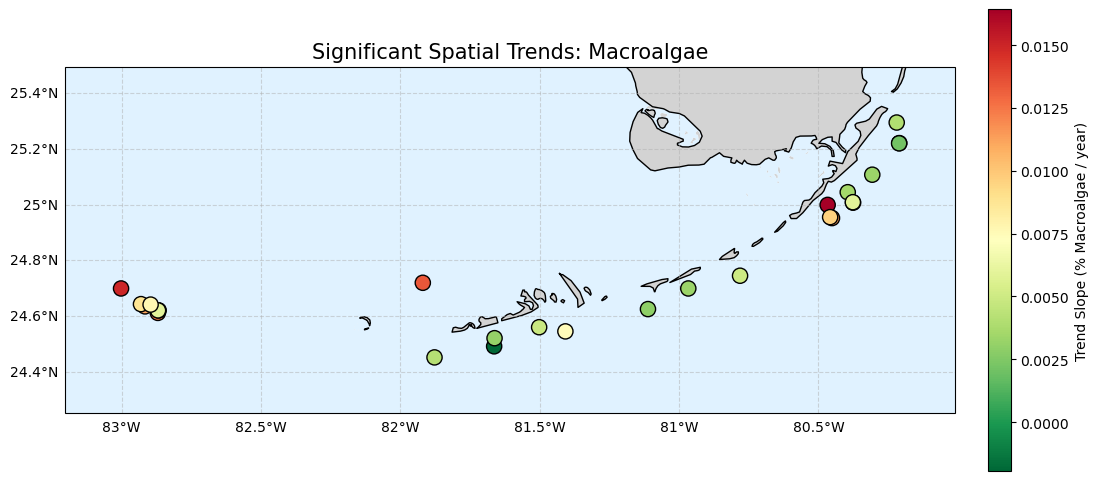

In [6]:
taxagroups_path_fk = os.path.join(data_dir_fk, "CREMP_Pcover_TaxaGroups_2024.csv")
taxagroups_path_dt = os.path.join(data_dir_dt, "DTCREMP_Pcover_TaxaGroups_2024.csv")
df_taxagroups_fk = pd.read_csv(taxagroups_path_fk)
df_taxagroups_dt = pd.read_csv(taxagroups_path_dt)
df_taxagroups = pd.concat([df_taxagroups_fk, df_taxagroups_dt], ignore_index=True)

# --- Spatial Analysis for a Selected Group ---
selected_group = 'Macroalgae'

# Group by Site and Year for the specific group
site_taxa_annual = df_taxagroups.groupby(['SiteName', 'SampleYear'])[selected_group].mean().reset_index()

# Calculate trends for this group at each individual site
site_taxa_stats = []
for site in site_taxa_annual['SiteName'].unique():
    site_data = site_taxa_annual[site_taxa_annual['SiteName'] == site]
    if len(site_data) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(site_data['SampleYear'], site_data[selected_group])
        site_taxa_stats.append({'SiteName': site, 'Slope': slope, 'P_Value': p_value})

df_taxa_map = pd.DataFrame(site_taxa_stats)

# Merge with coordinates and filter for significance (p < 0.05)
df_taxa_map = pd.merge(df_taxa_map, df_coords, left_on='SiteName', right_on='Site_name')
df_sig_map = df_taxa_map[df_taxa_map['P_Value'] < 0.05].copy()

# Render the Map
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add High-Res Features
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1)
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#e0f2ff')

# Plot Trends
sc = ax.scatter(df_sig_map['lonDD'], df_sig_map['latDD'], 
                c=df_sig_map['Slope'], cmap='RdYlGn_r', 
                s=120, edgecolor='black', transform=ccrs.PlateCarree(), zorder=3)

# Add Legend/Colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.03)
cbar.set_label(f'Trend Slope (% {selected_group} / year)')

# Set extent and labels
ax.set_extent([df_coords['lonDD'].min()-0.2, df_coords['lonDD'].max()+0.2, 
               df_coords['latDD'].min()-0.2, df_coords['latDD'].max()+0.2])
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

plt.title(f'Significant Spatial Trends: {selected_group.replace("_", " ")}', fontsize=15)
plt.show()

#### Plot time series of taxa groups

Taxa-Level Trend Analysis (All Sites Integrated):


,Taxa,Slope,P_Value,R_Squared
6,Substrate,-0.005758,0.000022,0.492548
5,StonyCoral,-0.000997,0.000063,0.453045
4,Seagrass,-0.000218,0.000003,0.564022
2,Others,0.000100,0.000685,0.352515
9,Zoanthidea,0.000175,0.000211,0.404159
1,Octocoral,0.000735,0.049627,0.135303
3,Porifera,0.000839,0.000006,0.539026
0,Macroalgae,0.003885,0.000040,0.470590
7,Unknown,NaN,NaN,NaN
8,Urchins,NaN,NaN,NaN


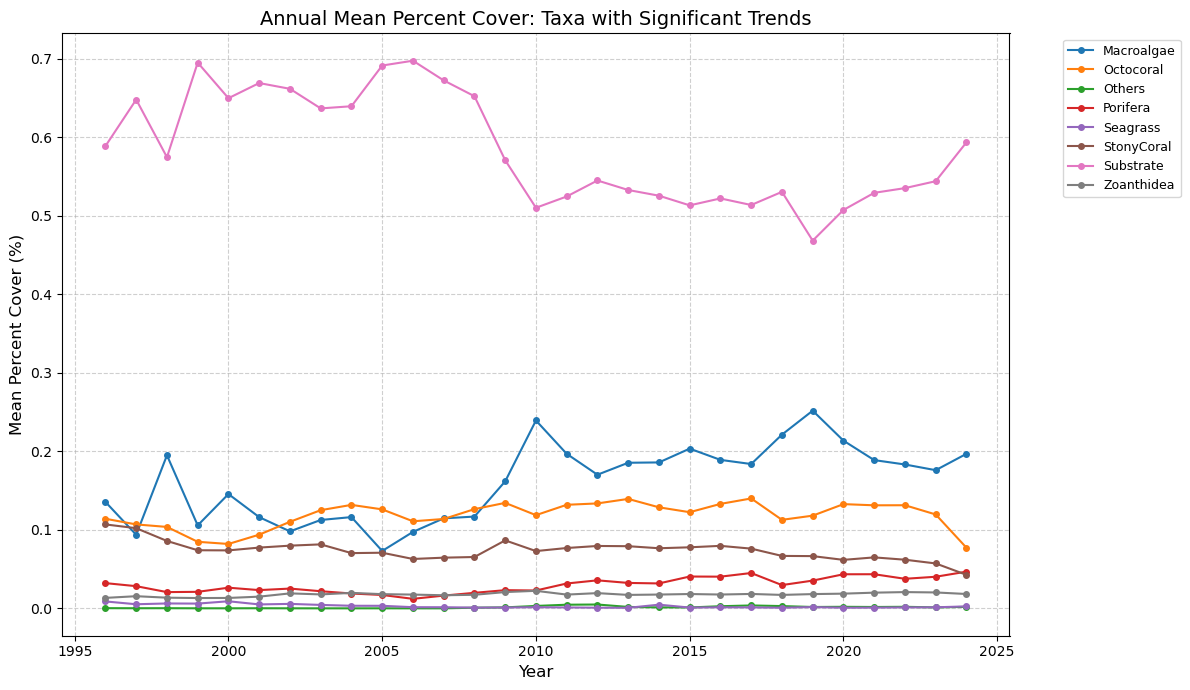

In [7]:
# Identify taxa columns (from index 11 onwards)
taxa_list = df_taxagroups.columns[11:].tolist()

# Aggregate data by Year for the entire region
# Calculate the mean percent cover for every taxa across all sites per year
taxa_annual = df_taxagroups.groupby('SampleYear')[taxa_list].mean().reset_index()
# Calculate Linear Trends for each taxa
taxa_stats = []

for taxa in taxa_list:
    # Remove years where the taxa might have zero data if necessary. 
    y = taxa_annual[taxa]
    x = taxa_annual['SampleYear']
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    taxa_stats.append({
        'Taxa': taxa,
        'Slope': slope,
        'P_Value': p_value,
        'R_Squared': r_value**2
    })

df_taxa_trends = pd.DataFrame(taxa_stats)

# Identify significant taxa (p < 0.05)
significant_taxa = df_taxa_trends[df_taxa_trends['P_Value'] < 0.05].copy()
# significant_taxa = df_taxa_trends

print("Taxa-Level Trend Analysis (All Sites Integrated):")
display(df_taxa_trends.sort_values('Slope', ascending=True))

# Render Time Series Plot for Significant Taxa Only (Excluding Substrate)
if not significant_taxa.empty:
    plt.figure(figsize=(12, 7))

    for taxa in significant_taxa['Taxa']:
        # --- Skip 'Substrate' ---
        if taxa == '':
            continue
            
        plt.plot(taxa_annual['SampleYear'], taxa_annual[taxa], 
                 marker='o', markersize=4, label=f"{taxa}")

    plt.title('Annual Mean Percent Cover: Taxa with Significant Trends', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Mean Percent Cover (%)', fontsize=12)
    
    # The legend will now automatically exclude Substrate because it was never plotted
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("No species showed statistically significant trends.")

#### First versus last-year comparison with boxplot

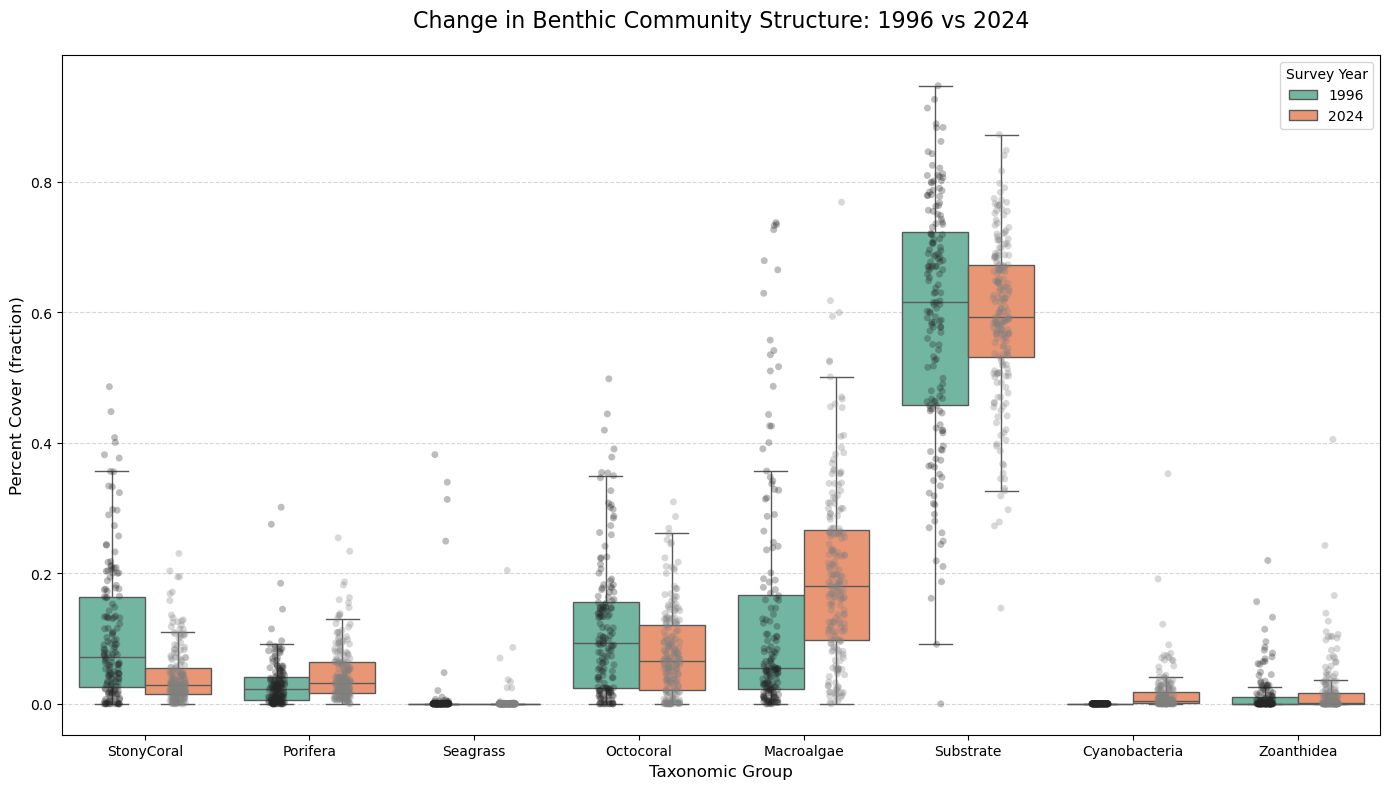

In [8]:
# Identify the first and last year of the time series
first_year = df_taxagroups['SampleYear'].min()
last_year = df_taxagroups['SampleYear'].max()

# Filter the dataset for these two years only
df_comparison = df_taxagroups[df_taxagroups['SampleYear'].isin([first_year, last_year])]

# Define the categories for the plot
categories = ['StonyCoral', 'Porifera', 'Seagrass', 'Octocoral', 'Macroalgae', 'Substrate', 'Cyanobacteria', 'Zoanthidea']

# Reshape data from 'wide' to 'long' format for Seaborn
df_melted = df_comparison.melt(
    id_vars=['SampleYear'], 
    value_vars=categories, 
    var_name='Category', 
    value_name='PercentCover'
)

# Render the Box-and-Whiskers plot
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=df_melted, 
    x='Category', 
    y='PercentCover', 
    hue='SampleYear', 
    palette='Set2',
    showfliers=False  # Optional: hides outliers for a cleaner look at the distributions
)

# Add jittered points to show the raw station data (optional)
sns.stripplot(
    data=df_melted, 
    x='Category', 
    y='PercentCover', 
    hue='SampleYear', 
    dodge=True, 
    alpha=0.3, 
    palette='dark:grey',
    legend=False
)

# Formatting for presentation
plt.title(f'Change in Benthic Community Structure: {first_year} vs {last_year}', fontsize=16, pad=20)
plt.ylabel('Percent Cover (fraction)', fontsize=12)
plt.xlabel('Taxonomic Group', fontsize=12)
plt.legend(title='Survey Year', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### Percentile-based baseline and scoring table for the reef-EBQI index

In [10]:
# Use the entire dataset as the baseline (instead of just 1996)
df_baseline = df_taxagroups.copy()

# Define our target categories
pos_indicators = ['StonyCoral', 'Seagrass', 'Octocoral']
neg_indicators = ['Macroalgae', 'Porifera', 'Substrate', 'Cyanobacteria', 'Zoanthidea']
all_indicators = pos_indicators + neg_indicators

# Calculate percentiles (20th, 40th, 60th, 80th) across the whole time series
percentiles = [0.2, 0.4, 0.6, 0.8]
baseline_stats = df_baseline[all_indicators].quantile(percentiles).T
baseline_stats.columns = ['20th', '40th', '60th', '80th']

# Create the S-Score reference table with inclusive logic
s_score_table = []

for category in all_indicators:
    p20 = baseline_stats.loc[category, '20th']
    p40 = baseline_stats.loc[category, '40th']
    p60 = baseline_stats.loc[category, '60th']
    p80 = baseline_stats.loc[category, '80th']
    
    if category in pos_indicators:
        s_score_table.append({
            'Category': category,
            'Type': 'Positive (Higher is Better)',
            'S=0 (<20th)': f"< {p20:.4f}",
            'S=1 (20-40th)': f"{p20:.4f} - {p40:.4f}",
            'S=2 (40-60th)': f"{p40:.4f} - {p60:.4f}",
            'S=3 (60-80th)': f"{p60:.4f} - {p80:.4f}",
            'S=4 (>80th)': f"> {p80:.4f}"
        })
    else:
        # --- Using <= logic to handle cases where thresholds are 0 ---
        # This ensures that a value of 0 (absence of stressor) always gets the highest score.
        s_score_table.append({
            'Category': category,
            'Type': 'Negative (Lower is Better)',
            'S=4 (<=20th)': f"<= {p20:.4f}", # Changed < to <=
            'S=3 (20-40th)': f"{p20:.4f} - {p40:.4f}",
            'S=2 (40-60th)': f"{p40:.4f} - {p60:.4f}",
            'S=1 (60-80th)': f"{p60:.4f} - {p80:.4f}",
            'S=0 (>80th)': f"> {p80:.4f}"
        })

df_s_ref = pd.DataFrame(s_score_table)

print("reef-EBQI S-Score Thresholds (Based on Entire Time Series):")
display(df_s_ref)

reef-EBQI S-Score Thresholds (Based on Entire Time Series):


,Category,Type,S=0 (<20th),S=1 (20-40th),S=2 (40-60th),S=3 (60-80th),S=4 (>80th),S=4 (<=20th),S=3 (20-40th),S=1 (60-80th),S=0 (>80th)
0,StonyCoral,Positive (Higher is Better),< 0.0159,0.0159 - 0.0327,0.0327 - 0.0583,0.0583 - 0.1233,> 0.1233,NaN,NaN,NaN,NaN
1,Seagrass,Positive (Higher is Better),< 0.0000,0.0000 - 0.0000,0.0000 - 0.0000,0.0000 - 0.0000,> 0.0000,NaN,NaN,NaN,NaN
2,Octocoral,Positive (Higher is Better),< 0.0334,0.0334 - 0.0816,0.0816 - 0.1273,0.1273 - 0.1876,> 0.1876,NaN,NaN,NaN,NaN
3,Macroalgae,Negative (Lower is Better),NaN,NaN,0.0889 - 0.1727,NaN,NaN,<= 0.0308,0.0308 - 0.0889,0.1727 - 0.2900,> 0.2900
4,Porifera,Negative (Lower is Better),NaN,NaN,0.0136 - 0.0283,NaN,NaN,<= 0.0052,0.0052 - 0.0136,0.0283 - 0.0520,> 0.0520
5,Substrate,Negative (Lower is Better),NaN,NaN,0.5301 - 0.6234,NaN,NaN,<= 0.4232,0.4232 - 0.5301,0.6234 - 0.7279,> 0.7279
6,Cyanobacteria,Negative (Lower is Better),NaN,NaN,0.0012 - 0.0053,NaN,NaN,<= 0.0000,0.0000 - 0.0012,0.0053 - 0.0184,> 0.0184
7,Zoanthidea,Negative (Lower is Better),NaN,NaN,0.0000 - 0.0037,NaN,NaN,<= 0.0000,0.0000 - 0.0000,0.0037 - 0.0242,> 0.0242


#### Calculated the reef-EBQI using percentile-based S scores from the previous cell with manual overrides for zero-inflated taxa: Cyanobacteria and Zoanthidea

In [11]:
# Recalculate baseline thresholds from the full dataset for standard categories
categories = ['StonyCoral', 'Macroalgae', 'Seagrass', 'Octocoral', 'Porifera', 'Substrate', 'Cyanobacteria', 'Zoanthidea']
threshold_map = df_taxagroups[categories].quantile([0.2, 0.4, 0.6, 0.8]).to_dict()

# Define the status classification function
def get_status(score):
    if score >= 7.5: return 'High'
    if score >= 6.0: return 'Good'
    if score >= 4.5: return 'Moderate'
    if score >= 3.5: return 'Poor'
    return 'Bad'

# Updated Scoring Functions
def score_positive(x, cat_thresholds):
    t = [cat_thresholds[0.8], cat_thresholds[0.6], cat_thresholds[0.4], cat_thresholds[0.2]]
    if x > t[0]: return 4
    if x > t[1]: return 3
    if x > t[2]: return 2
    if x > t[3]: return 1
    return 0

def score_negative(x, cat_thresholds):
    t = [cat_thresholds[0.2], cat_thresholds[0.4], cat_thresholds[0.6], cat_thresholds[0.8]]
    if x <= t[0]: return 4
    if x <= t[1]: return 3
    if x <= t[2]: return 2
    if x <= t[3]: return 1
    return 0

# --- Manual Override Functions for Zero-Inflated Taxa ---
def score_cyano_manual(x):
    if x <= 0.0001: return 4
    if x <= 0.0012: return 3
    # Falling back to percentile logic or standard steps if higher than 0.0012
    if x <= 0.05: return 2
    if x <= 0.10: return 1
    return 0

def score_zoanthid_manual(x):
    if x <= 0.0001: return 4
    if x <= 0.0010: return 3
    if x <= 0.0037: return 2
    # Falling back to standard steps if higher
    if x <= 0.01: return 1
    return 0

# Apply the Refined reef-EBQI Formula with Exceptions
def calculate_refined_ebqi(row):
    comps = {
        'StonyCoral':    {'W': 15, 'S': score_positive(row['StonyCoral'], threshold_map['StonyCoral'])},
        'Macroalgae':    {'W': 10, 'S': score_negative(row['Macroalgae'], threshold_map['Macroalgae'])},
        'Seagrass':      {'W': 12, 'S': score_positive(row['Seagrass'],   threshold_map['Seagrass'])},
        'Octocoral':     {'W': 7,  'S': score_positive(row['Octocoral'],  threshold_map['Octocoral'])},
        'Porifera':      {'W': 5,  'S': score_negative(row['Porifera'],   threshold_map['Porifera'])},
        'Substrate':     {'W': 3,  'S': score_negative(row['Substrate'],  threshold_map['Substrate'])},
        # --- EXCEPTION HANDLERS ---
        'Cyanobacteria': {'W': 3,  'S': score_cyano_manual(row['Cyanobacteria'])},
        'Zoanthidea':    {'W': 2,  'S': score_zoanthid_manual(row['Zoanthidea'])}
    }
    
    sum_ws = sum(c['W'] * c['S'] for c in comps.values())
    sum_w = sum(c['W'] for c in comps.values())
    
    return (sum_ws / (4 * sum_w)) * 10

# 4. Calculate and Aggregate
df_taxagroups['reef_EBQI'] = df_taxagroups.apply(calculate_refined_ebqi, axis=1)
site_ebqi = df_taxagroups.groupby(['SiteName', 'SampleYear'])['reef_EBQI'].mean().reset_index()

# Update Status labels based on the new scores
site_ebqi['Status'] = site_ebqi['reef_EBQI'].apply(get_status)

print("reef-EBQI Results with Manual Overrides for Zero-Inflated Taxa:")
display(site_ebqi.sort_values(by=['SampleYear', 'reef_EBQI'], ascending=[False, False]).head())

reef-EBQI Results with Manual Overrides for Zero-Inflated Taxa:


,SiteName,SampleYear,reef_EBQI,Status
437,Eastern Sambo Shallow,2024,5.087719,Moderate
241,Cliff Green,2024,5.076754,Moderate
1269,Western Head,2024,4.572368,Moderate
768,Prolifera Patch,2024,4.546784,Moderate
1240,West Washer Women,2024,4.528509,Moderate


#### Mapping reef-EBQI Status with specific conditions: bad, poor, moderate, good, high, or All

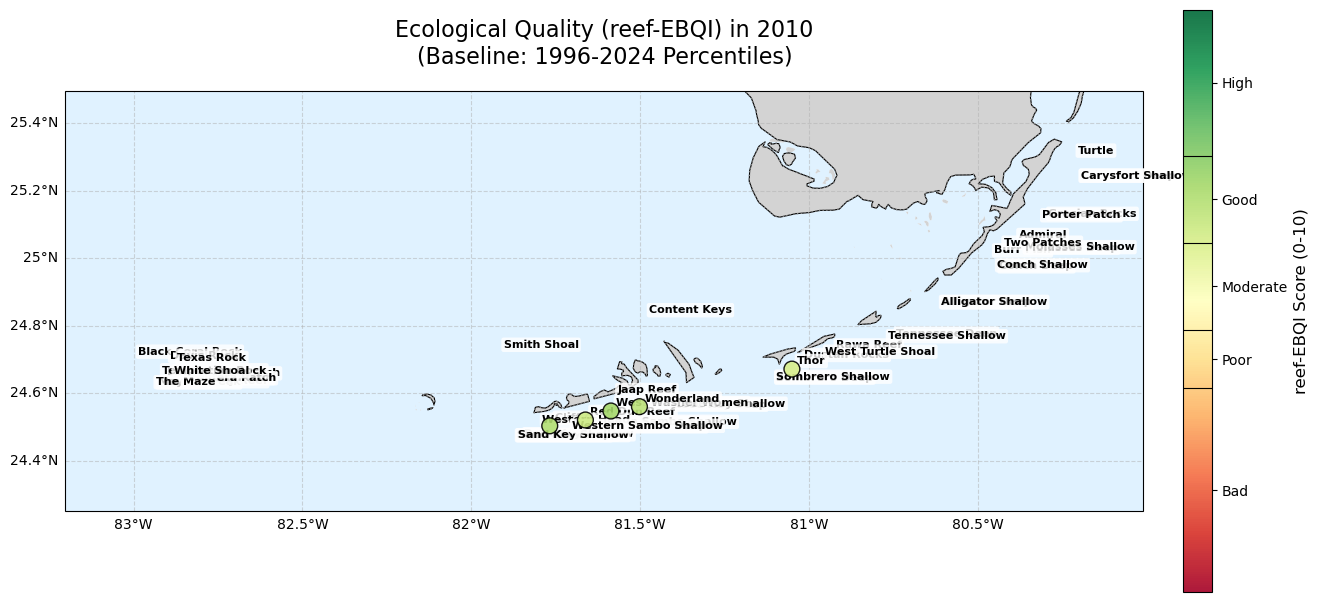

In [12]:
# Prepare Geographic Coordinates 
df_coords = df_stations[['Site_name', 'latDD', 'lonDD']].drop_duplicates(subset='Site_name')

# Merge EBQI results with coordinates
df_ebqi_map = pd.merge(site_ebqi, df_coords, left_on='SiteName', right_on='Site_name')

# Filter for the selected year
selected_year = 2010
df_ebqi_sel = df_ebqi_map[df_ebqi_map['SampleYear'] == selected_year].copy()

target_status = 'Good'  # Options: 'All', 'Bad', 'Poor', 'Moderate', 'Good', 'High'

if target_status == 'All':
    df_plot = df_ebqi_sel.copy()
else:
    df_plot = df_ebqi_sel[df_ebqi_sel['Status'] == target_status].copy()

# Setup the figure with a PlateCarree projection
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add high-resolution geographic features (Natural Earth 10m)
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8, zorder=2)
ax.add_feature(cfeature.STATES.with_scale('10m'), linestyle=':', edgecolor='gray', zorder=2)
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#e0f2ff', zorder=0)

# Plot the reef-EBQI values
sc = ax.scatter(df_plot['lonDD'], df_plot['latDD'], 
                c=df_plot['reef_EBQI'], cmap='RdYlGn', 
                s=130, edgecolor='black', alpha=0.9, 
                transform=ccrs.PlateCarree(), zorder=4, 
                vmin=0, vmax=10) # Fixed scale for easier comparison between years

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.03, shrink=0.6)
cbar.set_label('reef-EBQI Score (0-10)', fontsize=12)

# Define the midpoints of the status ranges for label placement
# Ranges: [0-3.5], [3.5-4.5], [4.5-6.0], [6.0-7.5], [7.5-10]
status_ticks = [1.75, 4.0, 5.25, 6.75, 8.75]
status_labels = ['Bad', 'Poor', 'Moderate', 'Good', 'High']

cbar.set_ticks(status_ticks)
cbar.set_ticklabels(status_labels)

# Optional: Add boundary lines on the colorbar for visual clarity
for threshold in [3.5, 4.5, 6.0, 7.5]:
    cbar.ax.axhline(threshold, color='black', linewidth=0.8)

# Set map limits and gridlines
ax.set_extent([df_ebqi_map['lonDD'].min() - 0.2, df_ebqi_map['lonDD'].max() + 0.2,
               df_ebqi_map['latDD'].min() - 0.2, df_ebqi_map['latDD'].max() + 0.2], 
              crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5, zorder=3)
gl.top_labels = False
gl.right_labels = False

# Label significant or problematic sites
# Labeling 'Bad' and 'Poor' status sites to highlight areas of concern
for idx, row in df_ebqi_sel.iterrows():
    if target_status != 'All' or row['Status'] in ['Bad', 'Poor']: 
        ax.text(row['lonDD'] + 0.015, row['latDD'] + 0.015, row['SiteName'],
                fontsize=8, transform=ccrs.PlateCarree(), fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8, ec='none'))

plt.title(f'Ecological Quality (reef-EBQI) in {selected_year}\n(Baseline: 1996-2024 Percentiles)', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

#### Spider-web plot by ecological status

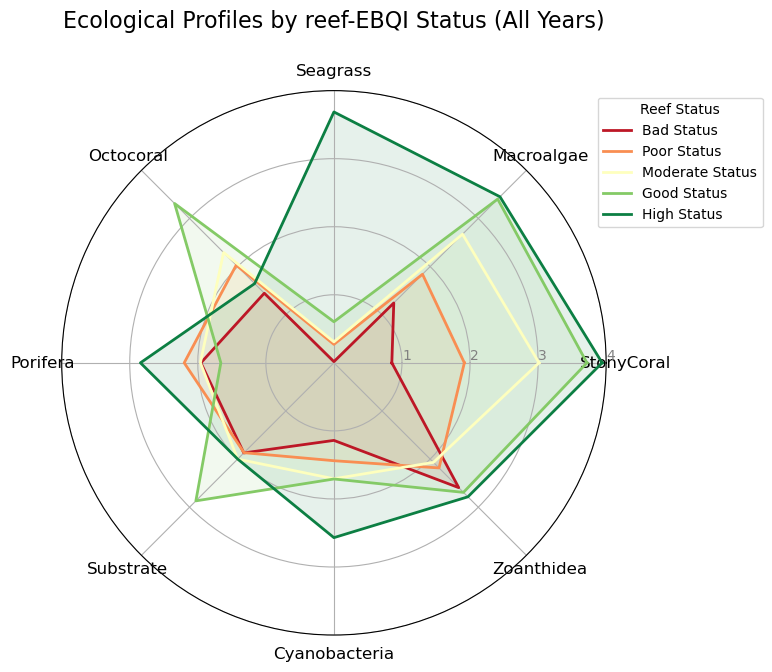

In [16]:
# Plot index for a selected year
# year_selection = 1996
# df_selected_year = df_taxagroups[df_taxagroups['SampleYear'] == year_selection].copy()

# Or use all years for average profiles
df_selected_year = df_taxagroups.copy()

# --- Define Status Order and matching Colors from 'RdYlGn' ---
status_levels = ['Bad', 'Poor', 'Moderate', 'Good', 'High']
# Mapping statuses to normalized 0-1 values to pick colors from the RdYlGn colormap
# (0.0=Red, 0.5=Yellow, 1.0=Green)
status_colors = {
    'Bad':      cm.RdYlGn(0.05),
    'Poor':     cm.RdYlGn(0.25),
    'Moderate': cm.RdYlGn(0.50),
    'Good':     cm.RdYlGn(0.75),
    'High':     cm.RdYlGn(0.95)
}

# Extract S-scores and include the reef_EBQI / Status
def get_scores_and_status(row):
    # Recalculate S-scores
    scores = {
        'StonyCoral':    score_positive(row['StonyCoral'], threshold_map['StonyCoral']),
        'Macroalgae':    score_negative(row['Macroalgae'], threshold_map['Macroalgae']),
        'Seagrass':      score_positive(row['Seagrass'],   threshold_map['Seagrass']),
        'Octocoral':     score_positive(row['Octocoral'],  threshold_map['Octocoral']),
        'Porifera':      score_negative(row['Porifera'],   threshold_map['Porifera']),
        'Substrate':     score_negative(row['Substrate'], threshold_map['Substrate']),
        'Cyanobacteria': score_negative(row['Cyanobacteria'], threshold_map['Cyanobacteria']),
        'Zoanthidea':    score_negative(row['Zoanthidea'],  threshold_map['Zoanthidea'])
    }
    # Calculate EBQI and Status to ensure we are grouping correctly
    ebqi = calculate_refined_ebqi(row)
    scores['Status'] = get_status(ebqi)
    return pd.Series(scores)

# --- Apply to get scores grouped by Status ---
df_scores_status = df_selected_year.apply(get_scores_and_status, axis=1)

# Prepare Plotting Basics
categories = ['StonyCoral', 'Macroalgae', 'Seagrass', 'Octocoral', 'Porifera', 'Substrate', 'Cyanobacteria', 'Zoanthidea']
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1] # Close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# --- Loop through each Status level to plot separate profiles ---
for status in status_levels:
    # Filter for the status and calculate mean S-scores
    subset = df_scores_status[df_scores_status['Status'] == status]
    
    if not subset.empty:
        mean_vals = subset[categories].mean().values.tolist()
        mean_vals += mean_vals[:1] # Close the circle
        
        # Plot the line
        ax.plot(angles, mean_vals, linewidth=2, linestyle='solid', 
                color=status_colors[status], label=f'{status} Status')
        
        # Fill the area with low alpha
        ax.fill(angles, mean_vals, color=status_colors[status], alpha=0.1)

# 4. Final Formatting
plt.xticks(angles[:-1], categories, color='black', size=12)
ax.set_rlabel_position(0)
plt.yticks([1, 2, 3, 4], ["1", "2", "3", "4"], color="grey", size=10)
plt.ylim(0, 4)

plt.title(f'Ecological Profiles by reef-EBQI Status (All Years)',
          size=16, color='black', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), title="Reef Status")

plt.tight_layout()
plt.show()